In [1]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap
import geopandas
import geoplot
import shapefile as shp

from sklearn.linear_model import LinearRegression, LogisticRegression
from VendorsParsingTools import *
from ForumParsingTools import *
from ProductListingParsingTools import *
from libs.milestone2Methods import *

# Table of content

## 1) General overview 
    1.0) Used datasets  
    1.1) Files obtained for each day  
    1.2) Services Uptime   
    1.3) Unusable files (celles qu'on a pas réussi à utiliser)  

## 2) Forum Analysis  
    2.1) Selected Features and DF  
    2.2.1) Data quality analysis
    2.2.2) Data Enrichment
    2.3) Index Stats Insight
    2.4) Topics Boards Insight

## 3) Market Analysis  
    3.1) Selected Features  
    3.2.1) Data Quality Analysis  
    3.2.2) Data Enrichment (typiquement en utilisant les données de grams)   
    3.3) Vendors Insight  
    3.4) Listings Insight  
   
## 4) Plan multi-variates analysis  
     ....
     


# 1) General overview

## 1.0) Used datasets

###  [_DN Archives (2013-2015)_](https://www.gwern.net/DNM-archives)

  - ##### Description
  The archive contains mostly scrapped _html_ pages from the many marketplaces, forums and other services (e.g. _Grams_ search engine) that were active during the period mentioned in the title. This raw data is organized first by service, then by date (meaning that for every service, one can go to a specific date and see a list of _html_ pages). Every archive is unambiguous on the format of the platform it represents, standard formatting can then be expected (e.g. item, profile, forum thread, list of items, etc.). However it is expected to be highly incomplete and most likely present inconsistencies.  All the directories are compressed using `tar.gz` compression. The whole archive is about `60 GiB` compressed and estimated to be about `1TiB` completely uncompressed.
  - ##### Data Management and Parsing
  Unshaken by the enormous size of this archive, a large amount of processing work is expected in order to filter out all the _html_ formatting data. Extracted data will most likely be placed into several `Pandas DataFrame` before being processed and prepared for statistical work.
  - ##### Data Enrichment and Processing
  Using online resources like the description of the dataset or tools from provided and found papers. As mentioned in the source description, the incompleteness of the Dataset will require a thorough study of the semantic behind the data as well as the use of adapted tools and methods.

### [_DNStats_](https://dnstats.net/)
  - #### Description
  TODO

## 1.1) Files obtained for each day

In [2]:
agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')

In [3]:
all_days_df = generateFileCount(forum_df, agora_df)

In [4]:
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])

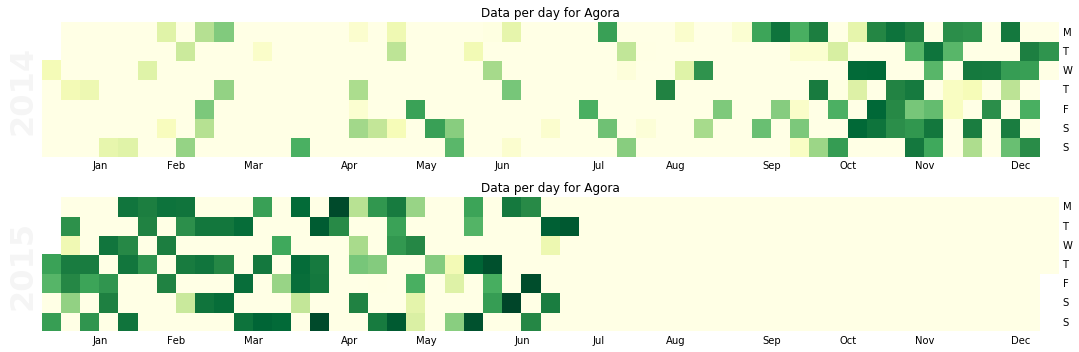

In [6]:
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

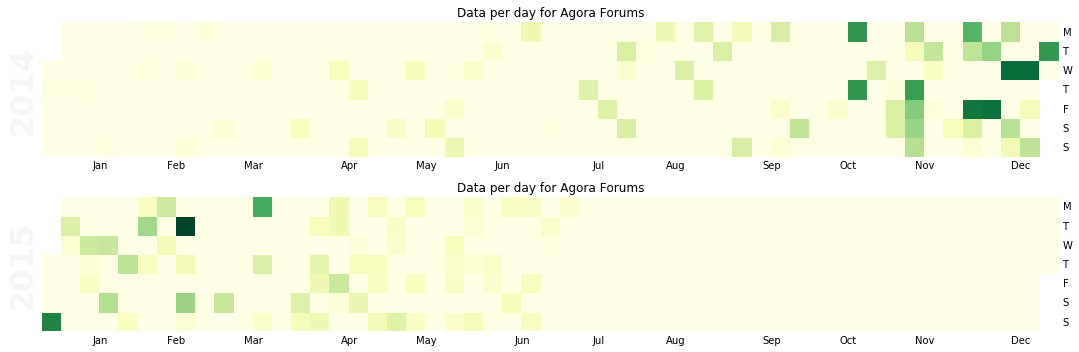

In [7]:
calmap.calendarplot(events_for,daylabels='MTWTFSS',cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0,fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora Forums'});

This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum.

We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora.

## 1.2) Services Uptime

In [8]:
agora_df1 = pd.read_csv('../data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

In [9]:
agora_df1

,sitename,siteup,timestamp,httpcode
0,Agora,1,2014-04-23 15:04:03,404
1,Agora,1,2014-04-23 15:15:05,404
2,Agora,1,2014-04-23 15:40:17,404
3,Agora,1,2014-04-23 15:45:03,404
4,Agora,1,2014-04-23 16:00:05,404
...,...,...,...,...
599388,Agora Forums,1,2017-03-25 22:34:01,503
599389,Agora Forums,1,2017-03-25 22:35:15,503
599390,Agora Forums,1,2017-03-25 22:40:20,503
599391,Agora Forums,1,2017-03-25 22:45:35,503


In [10]:
agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)

In [11]:
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

In [12]:
agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
forum_subdf1 = agora_df1[agora_df1['sitename'] == "Agora Forums"]

In [13]:
agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
forum_subdf1 = forum_subdf1.groupby(by='timestamp').mean()

In [14]:
forum_subdf1.groupby(by='timestamp').describe()

siteup                                                        \
            count      mean std       min       25%       50%       75%   
timestamp                                                                 
2014-04-24    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-25    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-26    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-27    1.0  0.989583 NaN  0.989583  0.989583  0.989583  0.989583   
2014-04-28    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
...           ...       ...  ..       ...       ...       ...       ...   
2017-03-22    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-23    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-24    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-25    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-26    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   

                     httpcode                                                  \
                 max    count       mean std        min        25%        50%   
timestamp                                                                       
2014-04-24  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-25  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-26  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-27  0.989583      1.0  203.15625 NaN  203.15625  203.15625  203.15625   
2014-04-28  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
...              ...      ...        ...  ..        ...        ...        ...   
2017-03-22  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-23  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-24  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-25  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-26  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   

                                  
                  75%        max  
timestamp                         
2014-04-24  200.00000  200.00000  
2014-04-25  200.00000  200.00000  
2014-04-26  200.00000  200.00000  
2014-04-27  203.15625  203.15625  
2014-04-28  200.00000  200.00000  
...               ...        ...  
2017-03-22  503.00000  503.00000  
2017-03-23  503.00000  503.00000  
2017-03-24  503.00000  503.00000  
2017-03-25  503.00000  503.00000  
2017-03-26  503.00000  503.00000  

[1053 rows x 16 columns]

/home/flou/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



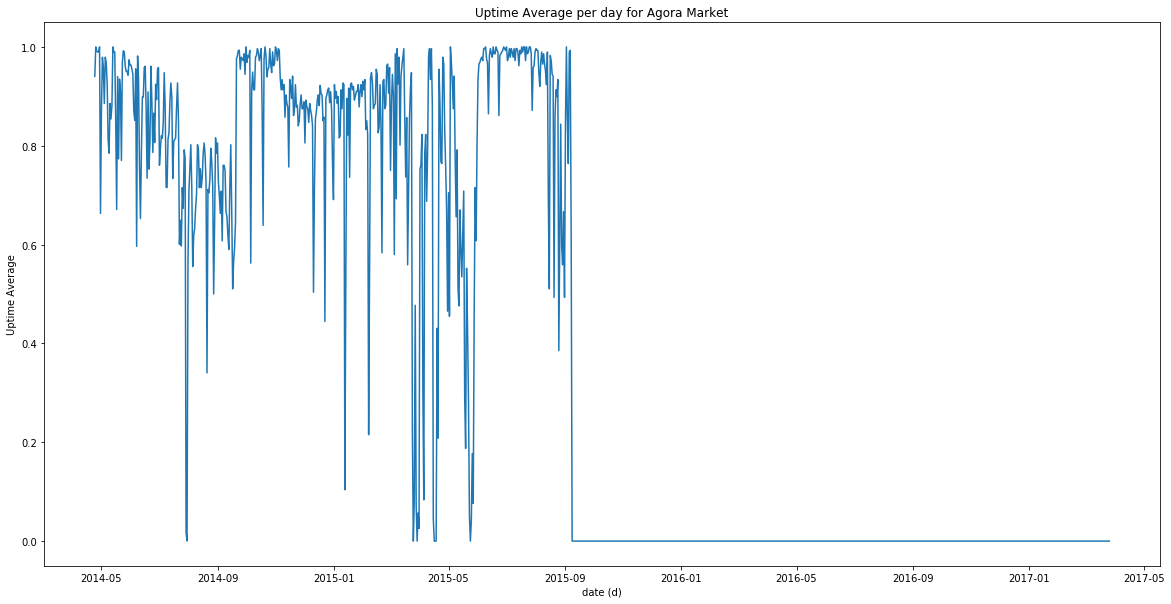

In [15]:
fig, ax1 = plt.subplots( figsize=(20,10))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(agora_subdf1.index, agora_subdf1['siteup'])
ax1.tick_params(axis='y')
plt.title('Uptime Average per day for Agora Market')
plt.show()

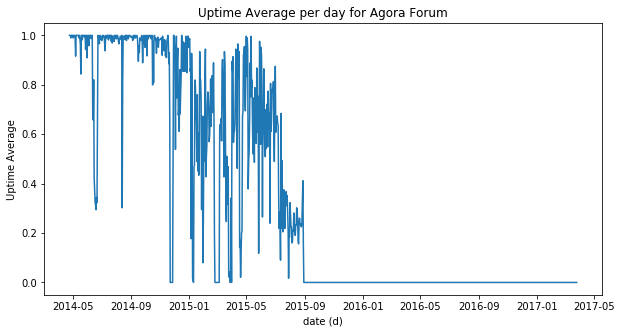

In [16]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(forum_subdf1.index, forum_subdf1['siteup'])
ax1.tick_params(axis='y')
plt.title('Uptime Average per day for Agora Forum')

plt.show()

We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum.

In [17]:
date_range = pd.date_range(start='2014-11-01', end='2014-12-01', freq='D')

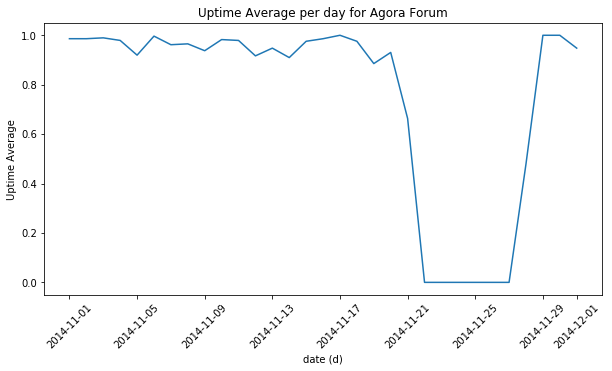

In [18]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(forum_subdf1.loc[date_range].index, forum_subdf1['siteup'][date_range])
ax1.tick_params(axis='y')
plt.xticks(rotation=45);
plt.title('Uptime Average per day for Agora Forum')

plt.show()

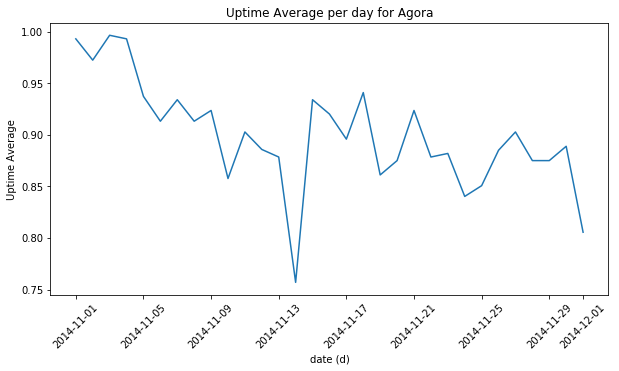

In [19]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(agora_subdf1.loc[date_range].index, agora_subdf1['siteup'][date_range])
ax1.tick_params(axis='y')
plt.xticks(rotation=45);
plt.title('Uptime Average per day for Agora')

plt.show()

Take a look at the period of Operation Onymous and see that there is a fall in the uptime average shortly after both for market and forum, but not at the same time. We also observe that shortly after the drop, the uptime average is back to normal for the forum and it has increased for the market but it tends to slow down.

## 1.3) Unusable Files

# 2) Forum Analysis

In [20]:
with open('../data/agora_forum_days.out') as f:
    dates = f.readlines()

def cut(s):
    return s[:-1]
cut_v = np.vectorize(cut)

dates = cut_v(dates)

def fixDate(r):
    
    return str(r).replace("Today", '')

In [21]:
forumDF = pd.read_csv('../saved_gen_df/forumDF_full_df.csv')

# 3) Market Analysis

## 3.2.2) Data Enrichment

In [2]:
price_df = pd.read_csv('../saved_gen_df/prices_and_stuff.csv')
price_df = price_df.drop(columns=['mean', 'std', 'min', '25%', '75%'])

In [3]:
# Get world mat
world = geopandas.read_file(
    geoplot.datasets.get_path('world')
)
sf = shp.Reader('../data/ne_50m_admin_0_countries.shp')
world_df = read_shapefile(sf)

In [4]:
world_df = world_df[['NAME', 'CONTINENT']]
world_df.rename(columns={'NAME':'name'}, inplace=True)
world_df = pd.merge(world, world_df, how='inner')

In [5]:
world_df['count'] = 0
world_df['continent_count'] = 0

In [13]:
DATE = "2015-07-12"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

In [14]:
world_df.to_csv("../saved_gen_df/listing_count_"+DATE+"_map_df.csv")

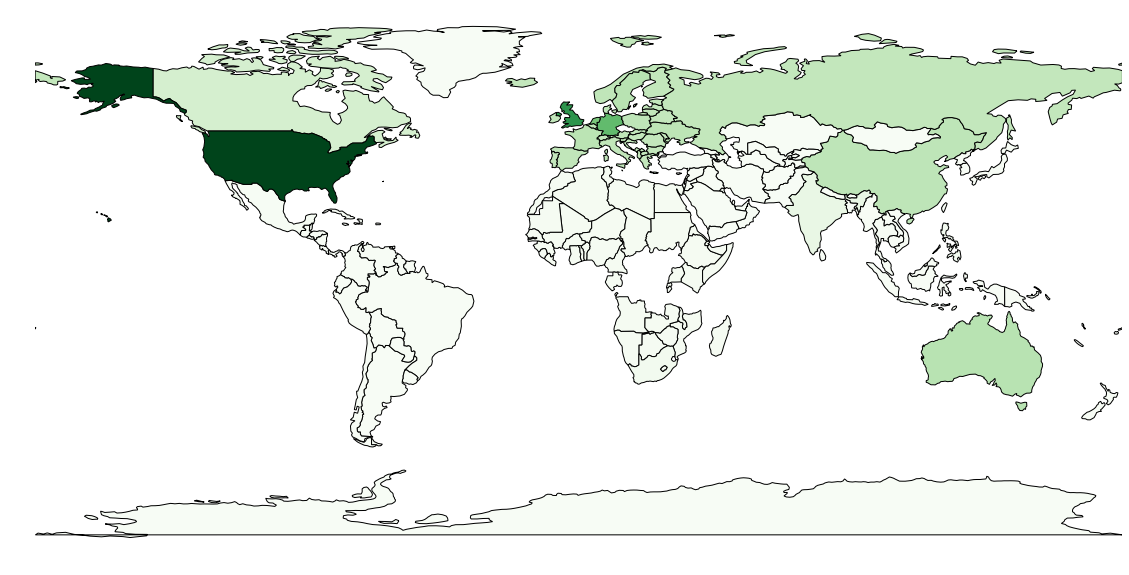

In [15]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));

In [16]:
DATE = "2014-06-09"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

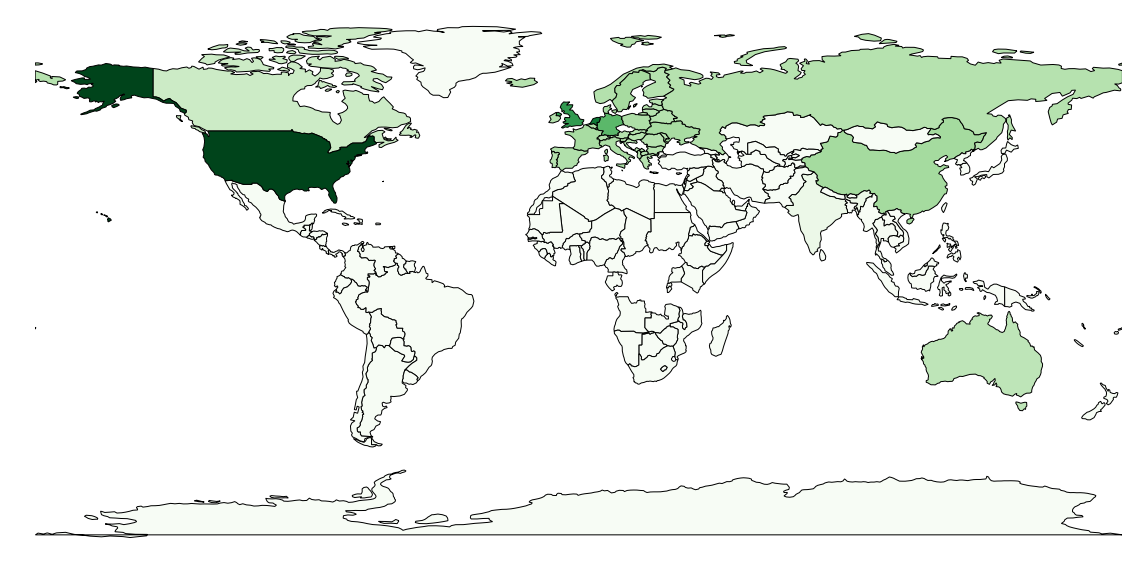

In [17]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));

## 3.3) Vendors Insight

In [ ]:
directory = "../data/agora/2014-04-06/vendor"
vendors = createVendorsDF(directory)

In [ ]:
vendors.head(10)

In [ ]:
sortedStats = createStatsAboutNumbOfDeals(Counter(vendors['#Deals']))
plt.bar(sortedStats.keys(),sortedStats.values());
plt.xticks(rotation=45);
plt.title('Number of deals per vendors');

In [ ]:
max(vendors['#products'])

In [ ]:
vendors['#products'].plot.hist(bins=50, logy=True)
plt.title('Number of products per vendor')
plt.xlabel('number of products')
plt.ylabel('number of vendors')
plt.show()

## 3.4) Listing insight

In [ ]:
# example for synthetic pages
directory = "../data/agora/2014-04-06/cat/arXCLhtVhq/"
productsDF = directoryToDF(directory)
productsDF.head(10)

In [ ]:
country = productsDF['from'].unique()
country